In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline


In [3]:
def make_points(row):
   return Point(row.Longitude, row.Latitude)

In [4]:
#Create dataframes and shape files. 
#Needed to merge parksmap and statedata to get a geodataframe to use for visualization

In [5]:
bio = pd.read_csv("species.csv",low_memory=False)
state_data = gpd.read_file('states/states.shp')
parks = pd.read_csv("parks.csv")
points = parks.apply(make_points,axis=1)
parks_map = gpd.GeoDataFrame(parks, geometry=points)
parks_map.crs = ('epsg:4326')
state_data.crs = ('epsg:4326')
state_parks = gpd.sjoin(parks_map,state_data, how ='inner',op = 'within')
state_data.set_index('STATE_NAME', inplace=True)

# Data Cleaning here

In [7]:
bio.drop(columns=['Unnamed: 13'])
bio.loc[(bio["Conservation Status"].isnull()),["Conservation Status"]] = 'Regular'
state_data['No. of Parks'] = state_parks['STATE_NAME'].value_counts()
state_data.loc[(state_data["No. of Parks"].isnull()),["No. of Parks"]] = 0

# First lets look at the number of parks in each state in this dataset

### This is where joining the geodataframes allowed me to use a heatmap

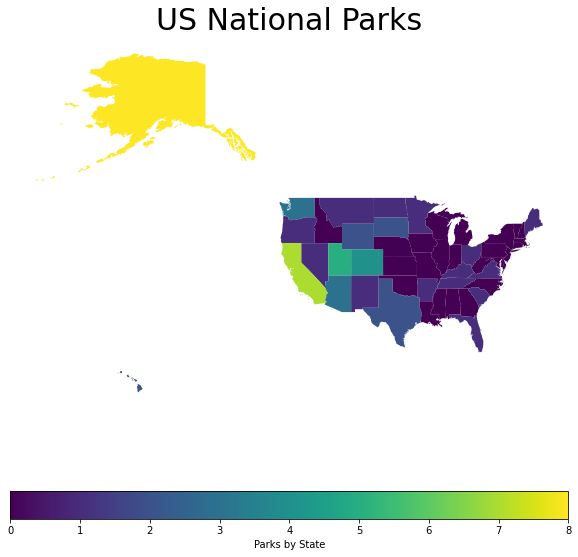

In [126]:
ax=state_data.plot(column='No. of Parks',
                   figsize=(10,10),
                   legend =True,
                   legend_kwds={'label': 'Parks by State','orientation':'horizontal'},
                   
                  )
ax.axis('off')
ax.set_title("US National Parks", fontsize =30);

## As we can see most of the parks are on the west coast. The state with the most parks is Alaska! Let's delve deeper by looking at the category counts of all the species in this dataset. 

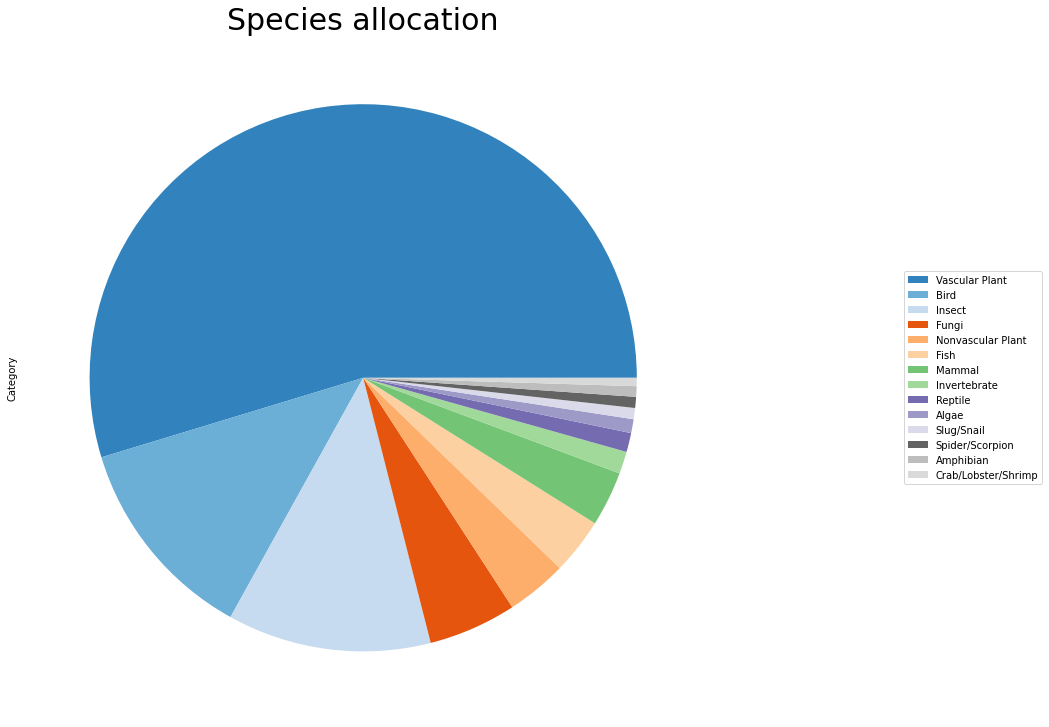

In [133]:
cmap='jet'
fig2,ax2 = plt.subplots(figsize=(5,10))
fig2.subplots_adjust(0.1,0,2,2)
bio["Category"].value_counts().plot.pie(labeldistance=None, cmap='tab20c',)
plt.title('Species allocation' ,fontsize=30)
plt.legend(loc='right',bbox_to_anchor=(0.5,0,1,1), );

### The vascular plants dwarf the rest of the types in terms of numbers and that is indicative of a healthy environment/ecosystem

## There are vast conservation efforts going on in these parks. Lets take a look at the various statuses of all species across all the parks. More information on statues can be found here https://explorer.natureserve.org/AboutTheData/Statuses

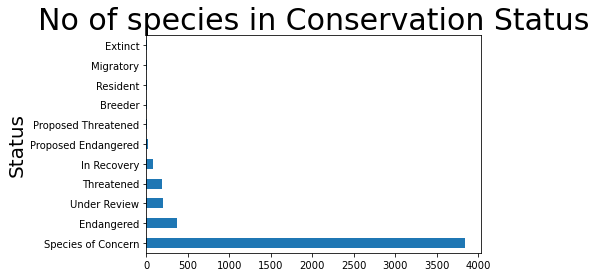

In [137]:
conservation_park = bio['Conservation Status'] != 'Regular'
plt.ylabel('Status', fontsize=20)
plt.title('No of species in Conservation Status', fontsize=30)
bio[conservation_park]["Conservation Status"].value_counts().plot.barh();


# Lets look at the breakdown of endangered species per park

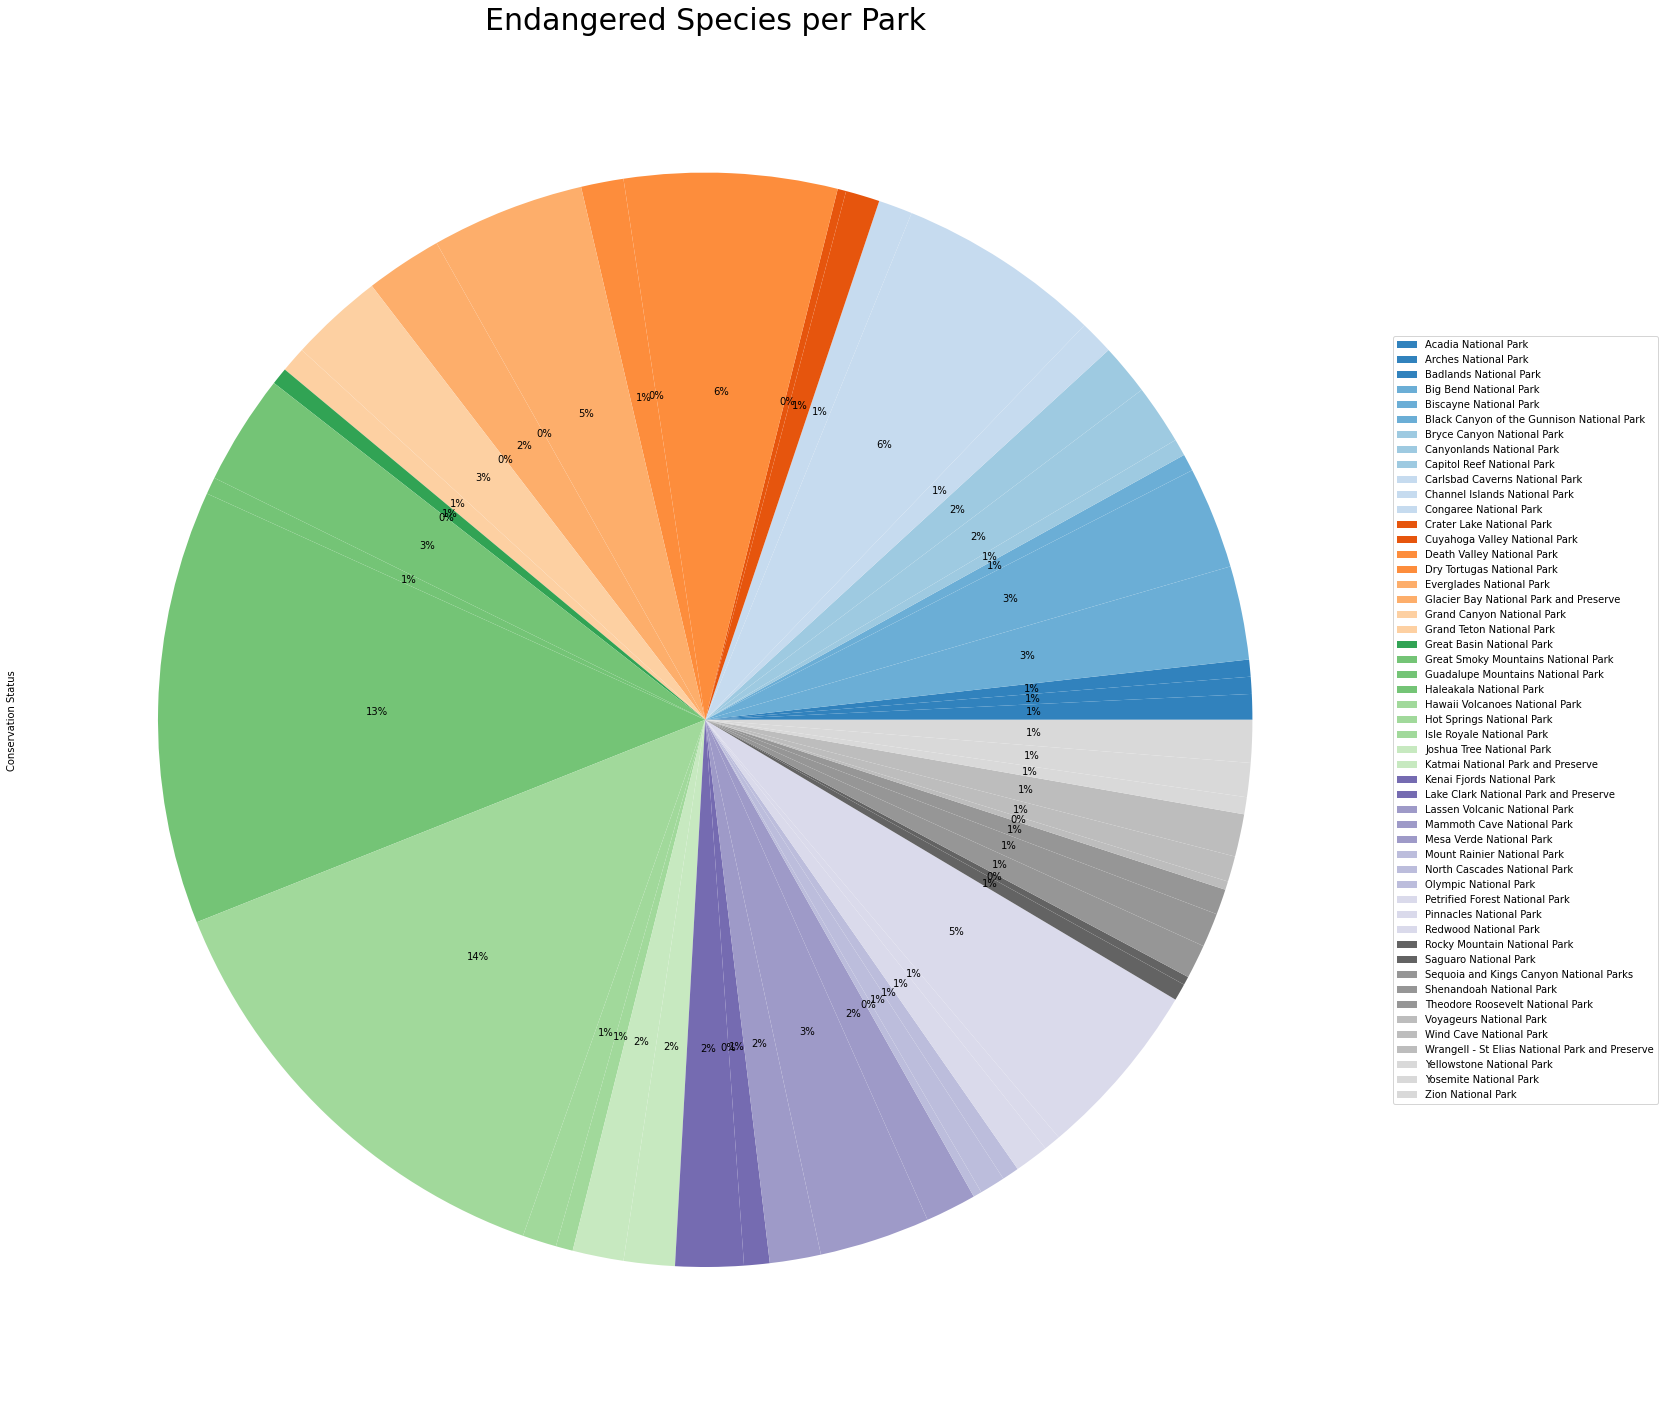

In [138]:
fig3,ax3 = plt.subplots(figsize=(10,15))
fig3.subplots_adjust(0.1,0,2,2)
spec_park = bio.groupby(["Park Name"])
x = spec_park['Conservation Status'].apply(lambda x: x.str.contains("Endangered").sum() )

x.plot.pie(labeldistance=None, cmap='tab20c',autopct='%1.0f%%')
plt.title('Endangered Species per Park', fontsize=30)
plt.legend(loc='right',bbox_to_anchor=(0.5,0,0.7,1), );


## What endangered species are unique to a park?

In [83]:
endangered_park = bio['Conservation Status'] == 'Endangered'

len(bio[endangered_park].duplicated())

374

### wow according to this data set every endangered species is unique to each park and there is no overlap or migration

## Let's look at the categories of the endangered species

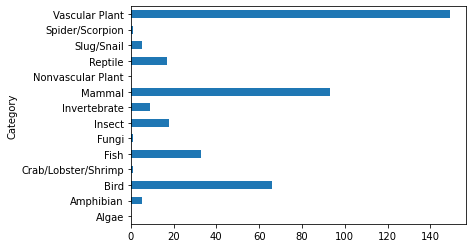

In [128]:
spec_species = bio.groupby(["Category"])
plt.title('Endangered Species per Park', fontsize=30)
spec_species['Conservation Status'].apply(lambda x: x.str.contains("Endangered").sum() ).plot.barh();

## According to this dataset the 2 parks that have the most endangered species are in Hawaii. Lets take a closer look at these parks and see if we can see any correlations.

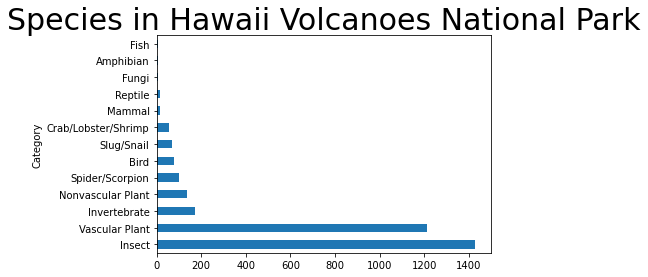

In [144]:
plt.title('Species in Hawaii Volcanoes National Park', fontsize=30)
spec_park["Category"].value_counts().loc['Hawaii Volcanoes National Park'].plot.barh();

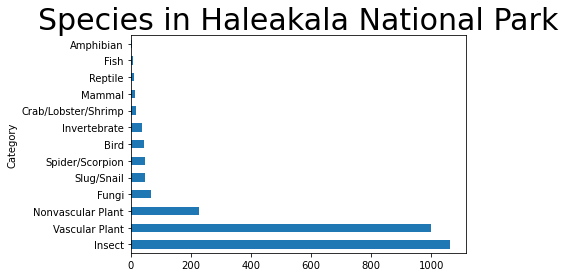

In [146]:
plt.title('Species in Haleakala National Park', fontsize=30)
spec_park["Category"].value_counts().loc['Haleakala National Park'].plot.barh();


## Interesting. it seems that the insect population is higher and the bird population is lower in both parks. These are two of many factors that contribute to Hawaii parks having high numbers of invasive species which can out compete the native species. This seems to help explain why more endangered species are recorded in Hawaii.
### This article talks more about invasive species and the conservation effort ongoing in Hawaii. https://www.nationalgeographic.com/travel/destinations/north-america/united-states/national-parks/invasive-species-threaten-native-plants-and-animals-visitors-can-help/